# `SoLEXS_Tools` Guide

# Introduction
`SoLEXS_Tools` is a Python package developed to facilitate the processing and preparation of the SoLEXS data. It provides essential tools and utilities generating and managing spectral data and calibration files, enabling users to perform spectral analysis using specialized tools such as XSPEC or Sherpa. 
The package includes SoLEXS calibration database (CALDB), which provides essential calibration files such as Auxiliary Response Files (ARF) and Redistribution Matrix Files (RMF).

This notebook provides a comprehensive guide to installing, setting up, and using the `SoLEXS_Tools` package for processing data from the SoLEXS.

# Installation and CALDB Setup
Download the source package [solexs_tools-1.3.tar.gz](https://github.com/abhilash-sw/solexs_tools/releases/download/v1.3/solexs_tools-1.3.tar.gz), install it using the following commands:

## Step 1: Install the Package

In [ ]:
!tar xvf solexs_tools-1.3.tar.gz
%cd solexs_tools
!python setup.py build
!python setup.py install

## Step 2: CALDB Setup (Mandatory)
The solexs_tools package requires a local, unzipped copy of the Calibration Database (CALDB) to function. The tools find this database using an environment variable called SOLEXS_CALDB.

You must perform this setup once after installation.

In [ ]:
import os

# 1. Extract the CALDB:
!solexs-caldb-extract ~/solexs_caldb

# 2. Set the environment variable for the current session
os.environ['SOLEXS_CALDB'] = os.path.expanduser('~/solexs_caldb')
print(f"SOLEXS_CALDB is set to: {os.environ['SOLEXS_CALDB']}")

## Importing Modules

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
%matplotlib inline
# plt.style.use(['science','notebook','grid'])

# Time Utilities
`SoLEXS_Tools` includes command-line interface (CLI) tools for converting between Unix timestamps and UTC.

In [2]:
# Convert Unix timestamp to UTC ISO 8601
!solexs-time2utc 1707735600

UTC Time: 2024-02-12T11:00:00+00:00


In [3]:
# Convert UTC ISO 8601 to Unix timestamp
!solexs-utc2time 2024-02-12T11:00:00

Unix Timestamp: 1707735600


# Data Processing Example

This notebook uses data from SOL-2024-10-01 as an example. To follow along, please download and extract the corresponding data for this date from the [PRADAN website](https://pradan.issdc.gov.in/pradan/al1) before running the notebook.


**Dataset:** SOL-2024-10-25

**Input Files:**
* `AL1_SOLEXS_20241025_SDD2_L1.pi.gz` (Level-1 PI Spectrogram)
* `AL1_SOLEXS_20241025_SDD2_L1.lc.gz` (Level-1 Light Curve)
* `AL1_SOLEXS_20241025_SDD2_L1.hk.gz` (Housekeeping Data)
* `AL1_SOLEXS_20241025_SDD2_L1.gti.gz` (Good Time Interval)

In [90]:
# Define filenames for 2024-10-25
date_str = "20241025"
dir_path = f'AL1_SLX_L1_{date_str}_v2.0/SDD2/'

pi_file = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1.pi.gz")
lc_file = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1.lc.gz")
hk_file = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1.hk.gz")
gti_file = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1.gti.gz")

## 1. Deadtime Correction

Before generating flux light curves or performing detailed spectral analysis, correct the deadtime of the detector using Housekeeping (HK) data.

In [48]:
pi_file_corr = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1_dt_corr.pi.gz")

In [49]:
!solexs-dtcorr -i $pi_file -hk $hk_file -o $pi_file_corr --clobber True

Output written to AL1_SLX_L1_20241025_v2.0/SDD2/AL1_SOLEXS_20241025_SDD2_L1_dt_corr.pi.gz.


## 2. Light Curve Generation

The Level-1 data includes light curve (`.lc`) covering the 2-22 keV range in count rate units. 

Users can also generate custom light curves from the Level-1 PI spectrogram (Type II) file, allowing for specific energy ranges, adjustable time binning, and conversion to physical flux units ($W/m^2$)

In [54]:
lc_file_corr = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1_dt_corr.lc")

In [62]:
!solexs-genlc -i $pi_file_corr -elo 2 -ehi 22 -o $lc_file_corr --clobber True

Output written to AL1_SLX_L1_20241025_v2.0/SDD2/AL1_SOLEXS_20241025_SDD2_L1_dt_corr.lc.


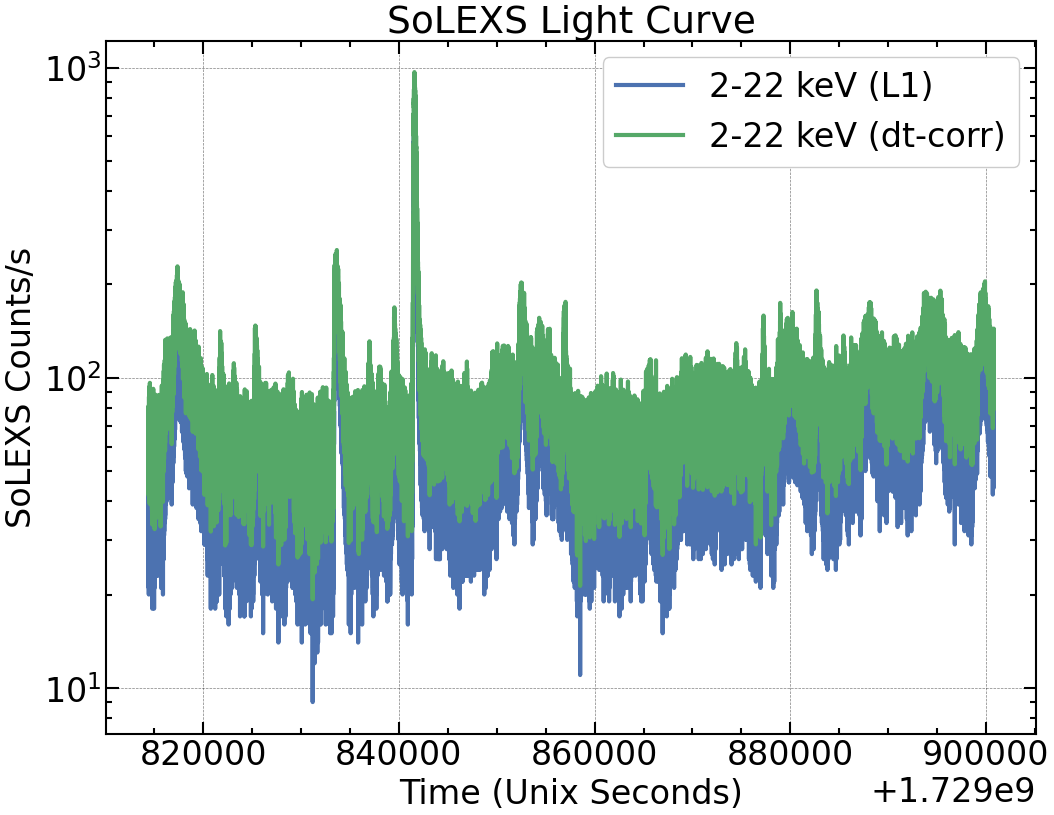

In [63]:
hdu_lc = fits.open(lc_file)
lc_data = hdu_lc[1].data

hdu_lc_corr = fits.open(lc_file_corr)
lc_data_corr = hdu_lc_corr[1].data

fig, ax = plt.subplots()
ax.semilogy(lc_data['TIME'], lc_data['COUNTS'],label='2-22 keV (L1)')
ax.semilogy(lc_data_corr['TIME'], lc_data_corr['FLUX'],label='2-22 keV (dt-corr)')
ax.set_title("SoLEXS Light Curve")
ax.set_xlabel("Time (Unix Seconds)")
ax.set_ylabel("SoLEXS Counts/s")
ax.legend()

In [64]:
lc_file_3_10keV_60sec_flux = os.path.join(dir_path,f"AL1_SOLEXS_{date_str}_SDD2_L1_dt_corr_3_10keV_60sec_flux.lc")

In [65]:
!solexs-genlc -i $pi_file_corr -elo 3 -ehi 10 -tbin 60 -o $lc_file_3_10keV_60sec_flux --flux True --clobber True

Output written to AL1_SLX_L1_20241025_v2.0/SDD2/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_3_10keV_60sec_flux.lc.


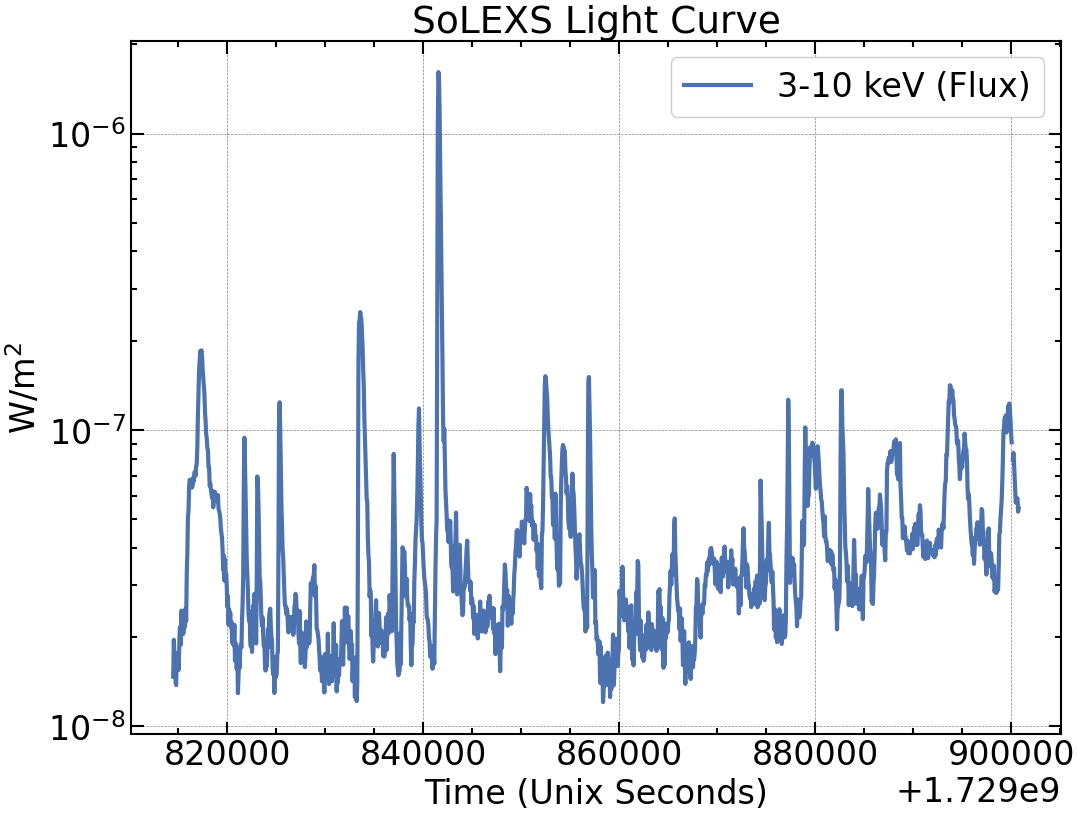

In [76]:
hdu_flux = fits.open(lc_file_3_10keV_60sec_flux)
flux_data = hdu_flux[1].data

fig, ax = plt.subplots()
ax.semilogy(flux_data['TIME'], flux_data['FLUX'],label='3-10 keV (Flux)')
ax.set_title("SoLEXS Light Curve")
ax.set_xlabel("Time (Unix Seconds)")
ax.set_ylabel(r"W/m$^{2}$")
ax.legend(loc=1)

## 3. Time Conversion

To extract a spectrum, Unix timestamps are required. An M1.2 class flare peaked at 2024-10-25T07:33 UTC. Calculate the corresponding Unix timestamp for this time.


In [77]:
!solexs-utc2time 2024-10-25T07:33:00

Unix Timestamp: 1729841580


In [78]:
!solexs-utc2time 2024-10-25T07:35:00

Unix Timestamp: 1729841700


* **TSTART**: `1729841580` 
* **TSTOP**: `1729841700` 

## 4. Spectral Generation

Generate the spectral files (Type I) for XSPEC/Sherpa analysis.

1.  Single Spectrum: Integrated spectrum over the selected flare duration.
2.  Multiple Spectra: Time-resolved spectra (e.g., every 5 seconds) during the flare.

In [79]:
tstart = 1729841580
tstop = 1729841700

# 1. Generate Single Spectrum
!solexs-genspec -i $pi_file_corr -tstart $tstart -tstop $tstop -gti $gti_file -o flare_spec --clobber True

Start Time: 2024-10-25T07:33:00+00:00
Stop Time: 2024-10-25T07:35:00+00:00
ARF: /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
RMF: /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf
Output written to flare_spec.pi.


In [83]:
# 2. Generate Time-Resolved Spectra (30s bins)
# Output will go into the 'spectra_series' directory
!solexs-genmultispec -i $pi_file_corr -tstart $tstart -tstop $tstop -tbin 30 -gti $gti_file -o spectra_series --clobber True

Start Time: 2024-10-25T07:33:00+00:00
Stop Time: 2024-10-25T07:35:00+00:00
Time Bin: 30.0 seconds
Output Directory: spectra_series
ARF: /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
RMF: /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf
Generated spectrum for time range 2024-10-25T07:33:00+00:00 to 2024-10-25T07:33:30+00:00: spectra_series/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_073300_073330
ARF: /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
RMF: /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf
Generated spectrum for time range 2024-10-25T07:33:30+00:00 to 2024-10-25T07:34:00+00:00: spectra_series/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_073330_073400
ARF: /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
RMF: /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf
Generated spectrum for time range 2024-10-25T07:34:00+00:00 to 2024-10-25T07:34:30+00:00: spectra_series/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_073400_073430
AR

In [71]:
from sherpa.astro.io import read_arf, read_rmf, read_pha
from sherpa.astro.plot import DataPHAPlot

In [80]:
pha = read_pha('flare_spec.pi',use_errors=True)

read ARF file /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
read RMF file /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf


In [81]:
pha.set_analysis('energy')
pha.notice(2.8,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1
print(pha)

name           = flare_spec.pi
channel        = Float64[340]
counts         = Float64[340]
staterror      = Float32[340]
syserror       = Float64[340]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = Int16[340]
exposure       = 94.19273
backscal       = 1.0
areascal       = 1.0
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = []


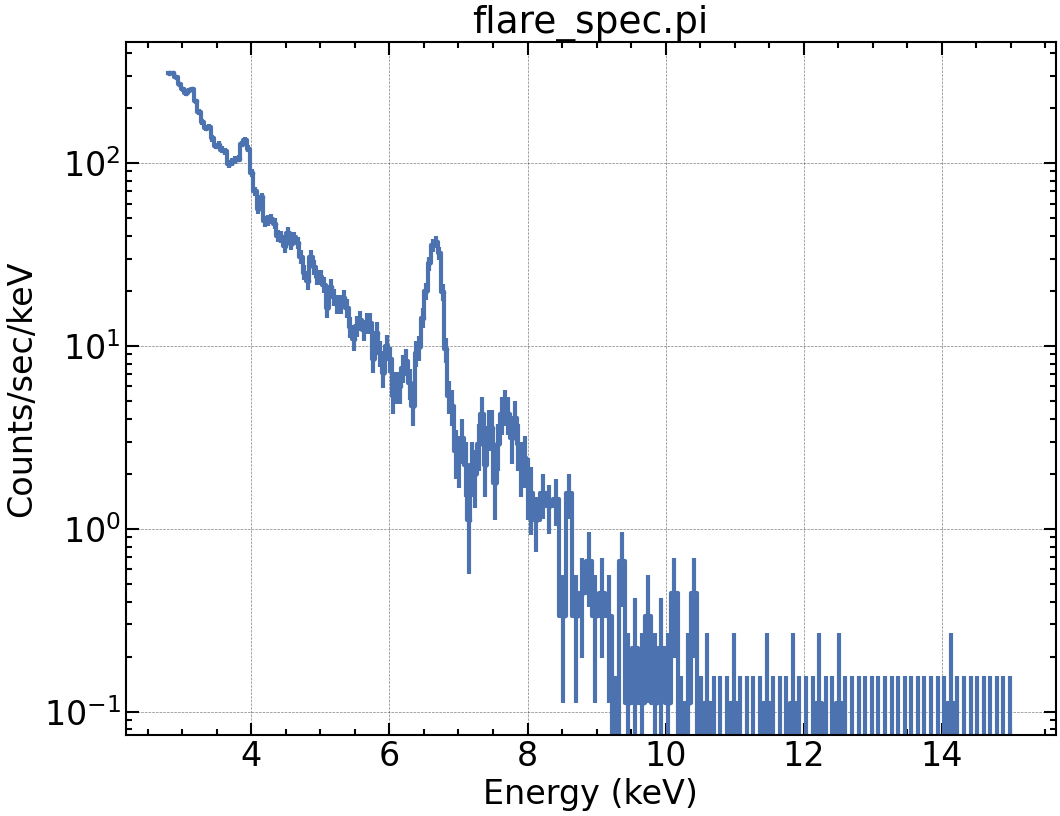

In [82]:
dplot1 = DataPHAPlot()
dplot1.prepare(pha)
dplot1.histo_prefs['linestyle'] = '-'
dplot1.plot(ylog=True,linestyle='solid')

In [84]:
pha = read_pha('spectra_series/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_073330_073400.pi',use_errors=True)

read ARF file /home/abhilash/solexs_caldb/arf/solexs_arf_SDD2_v1.arf
read RMF file /home/abhilash/solexs_caldb/response/rmf/solexs_gaussian_SDD2_v1.rmf


In [85]:
pha.set_analysis('energy')
pha.notice(2.8,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1
print(pha)

name           = spectra_series/AL1_SOLEXS_20241025_SDD2_L1_dt_corr_073330_073400.pi
channel        = Float64[340]
counts         = Float64[340]
staterror      = Float32[340]
syserror       = Float64[340]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = Int16[340]
exposure       = 23.55983
backscal       = 1.0
areascal       = 1.0
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = []


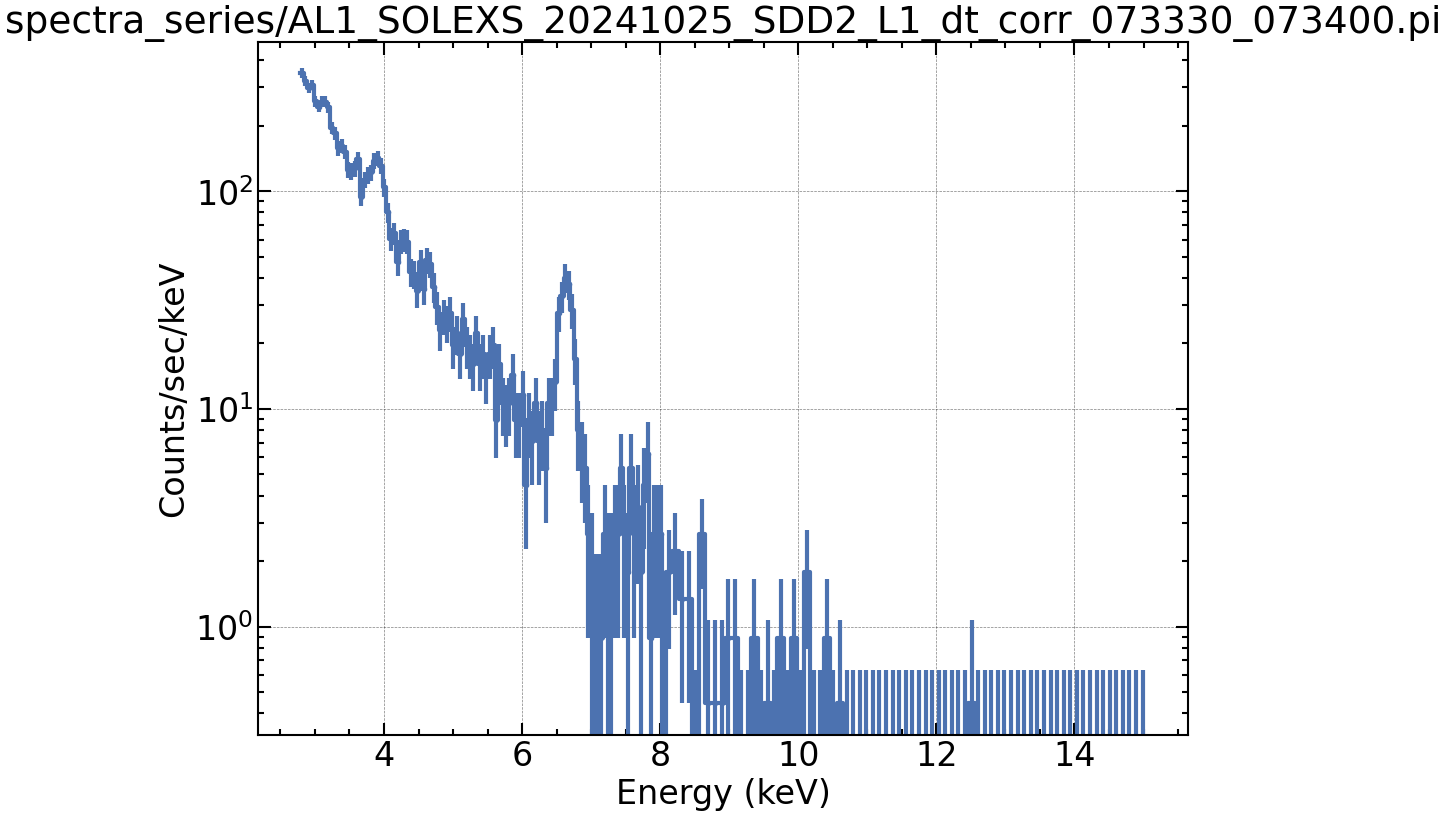

In [86]:
dplot1 = DataPHAPlot()
dplot1.prepare(pha)
dplot1.histo_prefs['linestyle'] = '-'
dplot1.plot(ylog=True,linestyle='solid')

## Spectral Fitting
![Spectral Fitting](img/spectral_isothermal_fitting_example.png)

In [88]:
from IPython.display import Video
Video('img/spectral_fitting_video.mp4', embed=True)

![Spectral Fitting](img/fit_temperature_20240212_M6.png)

# SoLEXS Observation Overview
![SoLEXS Observation Overview](img/solexs_lightcurve_with_flare_peaks_with_flareclass_2401-2510.png)